# 07 - Optimizers, Activation Functions, Regularization, and Learning Rate Schedulers
Prepared by Jan Christian Blaise Cruz

DLSU Machine Learning Group

# Preliminaries

This time, we'll accelerate computation using a GPU. 

Make sure you're using a GPU instance by going to Runtime > Change Runtime Type, and make sure that GPU is chosen in the dropdown box.

You can see the type of GPU that you have at the moment by using the command below:

In [ ]:
!nvidia-smi

Fri Aug 21 02:22:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Alright, let's dive right in. Let's import our (starting today) standard imports. PyTorch is our main tool of choice, so we'll bring in all the standard submodules. We'll also bring in some helpers for our dataset.

Lastly, we'll seed the random number generator, then tell PyTorch what device we'll be using (in this case, a reference to our GPU).

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils

from tqdm import tqdm
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

np.random.seed(42)
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data and Models

We will once again use the MNIST dataset for our examples. Let's load the dataset, then convert them to PyTorch tensors. Lastly, we'll create dataloaders out of our data using batch size 32.

In [ ]:
mnist = fetch_openml('mnist_784')
X_train, X_test, y_train, y_test = train_test_split(mnist.data.astype(np.float32), 
                                                    mnist.target.astype(np.int), 
                                                    random_state=42)

# Convert to PyTorch Tensors
X_train = torch.from_numpy(X_train)
X_test  = torch.from_numpy(X_test)
y_train = torch.from_numpy(y_train)
y_test  = torch.from_numpy(y_test)

# Produce Dataloaders
bs = 32

train_data = data_utils.TensorDataset(X_train, y_train)
test_data  = data_utils.TensorDataset(X_test,  y_test)
train_loader = data_utils.DataLoader(train_data, batch_size=bs)
test_loader  = data_utils.DataLoader(test_data,  batch_size=bs)

Let's check for shapes.

In [ ]:
x, y = next(iter(train_loader))
print(x.shape, y.shape)
print(len(train_loader))

torch.Size([32, 784]) torch.Size([32])
1641


Let's code up a simple one-hidden layer neural network model so we can test things out.

In [ ]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = torch.sigmoid(out)
        out = self.fc2(out)
        return out

Then code a helper function for checking accuracy.

In [ ]:
def accuracy(y_pred, y):
    return torch.sum(torch.max(y_pred, 1)[1] == y).item() / len(y)

# Stochastic Gradient Descent

Let's start by taking a look at vanilla gradient descent. For the rest of this section of the notebook, we'll look at different optimization methods (based on gradient descent) and see how to implement them in PyTorch.

Vanilla gradient descent is the backbone of our work, so we'll start with that. Remember the update rule:

$$\theta_{t + 1} = \theta_t - \alpha \nabla_\theta J(\theta)$$

Let's instantiate a model and pass it to our GPU. We'll also use cross entropy as our loss function.

In [ ]:
model = MLPClassifier(input_dim=784, hidden_dim=128, output_dim=10).to(device)
criterion = nn.CrossEntropyLoss()

Let's train for 10 epochs using vanilla gradient descent.

In [ ]:
epochs = 10
learning_rate = 1e-4

for e in range(1, epochs + 1):
    train_loss, train_acc = 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y)

        model.zero_grad()
        loss.backward()

        # Gradient Descent
        with torch.no_grad():
            for param in model.parameters():
                param -= learning_rate * param.grad

        train_loss += loss.item()
        train_acc += accuracy(out, y)
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    test_loss, test_acc = 0, 0
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y)

        test_loss += loss.item()
        test_acc += accuracy(out, y)
    test_loss /= len(test_loader)
    test_acc /= len(test_loader)

    print("Epoch {:3d} | Train Loss {:.4f} | Test Loss {:.4f} | Train Acc {:.2f}% | Test Acc {:.2f}%".format(e, train_loss, test_loss, train_acc * 100, test_acc * 100))

Epoch   1 | Train Loss 2.1359 | Test Loss 1.9407 | Train Acc 31.00% | Test Acc 51.05%
Epoch   2 | Train Loss 1.8183 | Test Loss 1.7030 | Train Acc 59.20% | Test Acc 65.27%
Epoch   3 | Train Loss 1.6171 | Test Loss 1.5309 | Train Acc 69.08% | Test Acc 72.33%
Epoch   4 | Train Loss 1.4635 | Test Loss 1.3967 | Train Acc 74.27% | Test Acc 75.97%
Epoch   5 | Train Loss 1.3418 | Test Loss 1.2891 | Train Acc 77.21% | Test Acc 77.97%
Epoch   6 | Train Loss 1.2428 | Test Loss 1.1993 | Train Acc 79.19% | Test Acc 79.73%
Epoch   7 | Train Loss 1.1586 | Test Loss 1.1217 | Train Acc 80.78% | Test Acc 80.90%
Epoch   8 | Train Loss 1.0855 | Test Loss 1.0539 | Train Acc 82.04% | Test Acc 82.06%
Epoch   9 | Train Loss 1.0205 | Test Loss 0.9943 | Train Acc 82.99% | Test Acc 83.17%
Epoch  10 | Train Loss 0.9637 | Test Loss 0.9427 | Train Acc 83.89% | Test Acc 84.13%


A shorthand for that would be to use the torch.optim submodule, which contains an implementation of standard gradient descent.

In [ ]:
# optim.SGD()

While gradient descent is effective, it does have it's problems:
1. It's slow. It takes a lot of time and iterations to achieve a good solution.
2. It's sensitive to changes in the hyperparameters. You need to do a lot of runs to tune the learning rate, for example.
3. For neural networks (and other non-convex optimization) settings, it has trouble getting out of local minima and saddle points.

# Momentum

Let's solve the first problem with SGD.

Instead of relying purely on the gradient signals on the update step, why not use previous information to aid direction? In this case, we can say that if SGD is ramping up **momentum** during it's traversal of the loss surface, then we can keep pushing it towards directions that it's confident in.

We call this method **SGD with Momentum**. You can picture this optimizer like a ball rolling down a hill. As it moves further down, it speeds up, until it meets a bump that changes its direction with inertia. Mathematically, we represent the update step like this:

$$
v_t = \gamma v_{t-1} + \alpha \nabla_\theta J(\theta) \\
\theta_{t + 1} = \theta_t - v_t
$$

In this equation, $\gamma$ represents our "momentum" parameter. The higher the momentum parameter, the more informtion the optimizer will use from the previous update step.

Let's instantiate our neural network and loss function.

In [ ]:
model = MLPClassifier(input_dim=784, hidden_dim=128, output_dim=10).to(device)
criterion = nn.CrossEntropyLoss()

To keep track of which theta parameter matrices belong to which, we'll rely on PyTorch's built in parameter names.

In [ ]:
for n, p in model.named_parameters():
    print(n)

fc1.weight
fc1.bias
fc2.weight
fc2.bias


We'll keep a dictionary that contains information from the previous theta updates. We set our learning rate to 1e-4, and use a momentum value of 0.9.

In [ ]:
v_t = {n: torch.zeros(p.shape).to(device) for n, p in model.named_parameters()}
learning_rate = 1e-4
gamma = 0.9

In [ ]:
v_t['fc1.bias']

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')

And then we code up the optimizer.

In [ ]:
epochs = 10

for e in range(1, epochs + 1):
    train_loss, train_acc = 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y)

        model.zero_grad()
        loss.backward()

        # Gradient Descent
        with torch.no_grad():
            for name, param in model.named_parameters():
                v_t[name] = (gamma * v_t[name]) + (learning_rate * param.grad)
                param -= v_t[name]

        train_loss += loss.item()
        train_acc += accuracy(out, y)
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    test_loss, test_acc = 0, 0
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y)

        test_loss += loss.item()
        test_acc += accuracy(out, y)
    test_loss /= len(test_loader)
    test_acc /= len(test_loader)

    print("Epoch {:3d} | Train Loss {:.4f} | Test Loss {:.4f} | Train Acc {:.2f}% | Test Acc {:.2f}%".format(e, train_loss, test_loss, train_acc * 100, test_acc * 100))

Epoch   1 | Train Loss 1.3846 | Test Loss 0.9348 | Train Acc 71.11% | Test Acc 83.88%
Epoch   2 | Train Loss 0.7660 | Test Loss 0.6427 | Train Acc 86.25% | Test Acc 87.89%
Epoch   3 | Train Loss 0.5664 | Test Loss 0.5147 | Train Acc 88.81% | Test Acc 89.48%
Epoch   4 | Train Loss 0.4678 | Test Loss 0.4463 | Train Acc 89.97% | Test Acc 90.18%
Epoch   5 | Train Loss 0.4090 | Test Loss 0.4008 | Train Acc 90.85% | Test Acc 90.64%
Epoch   6 | Train Loss 0.3687 | Test Loss 0.3699 | Train Acc 91.42% | Test Acc 91.27%
Epoch   7 | Train Loss 0.3390 | Test Loss 0.3469 | Train Acc 91.93% | Test Acc 91.50%
Epoch   8 | Train Loss 0.3166 | Test Loss 0.3284 | Train Acc 92.33% | Test Acc 91.87%
Epoch   9 | Train Loss 0.2982 | Test Loss 0.3137 | Train Acc 92.72% | Test Acc 92.11%
Epoch  10 | Train Loss 0.2832 | Test Loss 0.3036 | Train Acc 93.05% | Test Acc 92.18%


As we can see, our model learned faster from using Momentum than with just pure gradient descent. To use momentum in PyTorch optimizers, we use the following shorthand:

In [ ]:
# optim.SGD(momentum=0.9)

Now, let's work on problem 2. SGD requires you to tune your hyperparameters, which can be costly. Learning rate is the most important hyperparameter. If it's too small, training can proceed very slowly. If it's too big, training can diverge or fail.

# RMSProp

The RMSProp (Hinton, 2012) algorithm was proposed by Geoffrey Hinton on session 6 of his Coursera MOOC (it didn't come from a paper!)

The idea of RMSProp is essentially scaling the learning rate based on the weighted moving average of our gradients. If our gradients are moving slowly (meaning, little changes are made), then we do smaller updates. If the gradients are moving faster (meaning, the parameters haven't "found their place" yet), then we do larger updates.

the equation for $E[g^2]_t$ represents this moving average. We use a $\beta$ parameter to essentially control how much information we take from the previous update step and how much information to take from the current one. Afterwards, we then take the root mean square of that moving average to scale the learning rate. This is where RMSProp gets its name.

The equations for the update step are as follows:

$$
g_t = \nabla_\theta J(\theta) \\
E[g^2]_t = \beta E[g^2]_{t-1} + (1 - \beta) g^2_t \\
\theta_{t+1} = \theta_t - \frac{\alpha}{\sqrt{E[g^2]_t + \epsilon}} g_t
$$

Now to see it in action, we'll create a new instance of our neural network and loss function.

In [ ]:
model = MLPClassifier(input_dim=784, hidden_dim=128, output_dim=10).to(device)
criterion = nn.CrossEntropyLoss()

We'll again use a dictionary to store our previous averages. Hinton recommends a $\beta$ of 0.9 and a default learning rate of 0.001.

In [ ]:
history = {n: torch.zeros(p.shape).to(device) for n, p in model.named_parameters()}
learning_rate = 0.001
beta = 0.9
epsilon = 1e-8

Let's implement it to train for 10 epochs.

In [ ]:
epochs = 10

for e in range(1, epochs + 1):
    train_loss, train_acc = 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y)

        model.zero_grad()
        loss.backward()

        # Gradient Descent
        with torch.no_grad():
            for name, param in model.named_parameters():
                history[name] = (beta * torch.square(history[name])) + ((1 - beta) * torch.square(param.grad))
                param -= learning_rate / torch.sqrt(history[name] + epsilon) * param.grad

        train_loss += loss.item()
        train_acc += accuracy(out, y)
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    test_loss, test_acc = 0, 0
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y)

        test_loss += loss.item()
        test_acc += accuracy(out, y)
    test_loss /= len(test_loader)
    test_acc /= len(test_loader)

    print("Epoch {:3d} | Train Loss {:.4f} | Test Loss {:.4f} | Train Acc {:.2f}% | Test Acc {:.2f}%".format(e, train_loss, test_loss, train_acc * 100, test_acc * 100))

Epoch   1 | Train Loss 0.4608 | Test Loss 0.4077 | Train Acc 87.73% | Test Acc 90.58%
Epoch   2 | Train Loss 0.3721 | Test Loss 0.3606 | Train Acc 91.34% | Test Acc 91.85%
Epoch   3 | Train Loss 0.3318 | Test Loss 0.3415 | Train Acc 92.51% | Test Acc 92.38%
Epoch   4 | Train Loss 0.3067 | Test Loss 0.3283 | Train Acc 93.15% | Test Acc 93.02%
Epoch   5 | Train Loss 0.2853 | Test Loss 0.3268 | Train Acc 93.64% | Test Acc 93.16%
Epoch   6 | Train Loss 0.2726 | Test Loss 0.3027 | Train Acc 94.05% | Test Acc 93.84%
Epoch   7 | Train Loss 0.2547 | Test Loss 0.2859 | Train Acc 94.41% | Test Acc 94.20%
Epoch   8 | Train Loss 0.2397 | Test Loss 0.2918 | Train Acc 94.70% | Test Acc 94.13%
Epoch   9 | Train Loss 0.2332 | Test Loss 0.2758 | Train Acc 94.93% | Test Acc 94.35%
Epoch  10 | Train Loss 0.2227 | Test Loss 0.2830 | Train Acc 95.11% | Test Acc 94.26%


To use RMSProp in PyTorch, we simply use the shorthand from the torch.optim module:

In [ ]:
# optim.RMSprop(lr=0.001, alpha=0.9)

Now, we can mash Momentum and RMSProp together to make a better optimizer.

# Adam

Adaptive Moments Estimation (Kingma and Ba, 2014) is considered the "de facto" standard optimizer for Neural Networks, simply because it's very effective. It combines Momentum's idea of...well... momentum, as well as RMSProp's idea of scaling learning rates depending on the current and previous gradients.

Here are the equations for Adam's update rule:

$$
m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t \\
v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2 \\
\hat{m_t} = \frac{m_t}{1 - \beta_1^t} \\
\hat{v_t} = \frac{v_t}{1 - \beta_2^t} \\
\theta_{t + 1} = \theta_t - \frac{\alpha}{\sqrt{\hat{v_t}} + \epsilon} \hat{m_t}
$$

In this equation, $m_t$ is an approximation of the first moment (the expected mean of the distribution) and $v_t$ is an approximation of the second moment (the uncentered variance of the distribution). This is how the algorithm gets its name.

In easier words, we're essentially taking the weighted moving averages of both the gradient and the gradient squared. Since we initialize $m_t$ and $v_t$ to be zero at start, these estimates will be biased during the initial steps. To correct these, we'll make bias-corrected values $\hat{m_t}$ and $\hat{v_t}$.

We'll then use the variance (as a root mean square) to scale the learning rate, and the mean as a "momentum-influenced parameter update." Researchers describe Adam as like a "ball with friction" moving down a slope.

**In mathematics, a moment is a measure that refers to a function's graph. For probability distributions, these are (from zeroth to fourth): total probability, expected value/arithmetic mean, variance, skewness, and kurtosis.*

In [ ]:
model = MLPClassifier(input_dim=784, hidden_dim=128, output_dim=10).to(device)
criterion = nn.CrossEntropyLoss()

We'll use two dictionaries to keep track of our mean and variances. We'll use Karpathy's Constant 3e-4 as a base learning rate for Adam. The authors propose 0.9 and 0.999 as good values for our betas.

In [ ]:
m_t = {n: torch.zeros(p.shape).to(device) for n, p in model.named_parameters()}
v_t = {n: torch.zeros(p.shape).to(device) for n, p in model.named_parameters()}
learning_rate = 3e-4
b1, b2 = 0.9, 0.999
epsilon = 1e-8

We'll implement Adam and train for 10 epochs.

In [ ]:
epochs = 10

for e in range(1, epochs + 1):
    train_loss, train_acc = 0, 0

    for t, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y)

        model.zero_grad()
        loss.backward()

        # Gradient Descent
        with torch.no_grad():
            for name, param in model.named_parameters():
                m_t[name] = b1 * m_t[name] + (1 - b1) * param.grad
                v_t[name] = b2 * v_t[name] + (1 - b2) * torch.square(param.grad)
                hat_m = m_t[name] / (1 - b1 ** (t + 1))
                hat_v = v_t[name] / (1 - b2 ** (t + 1))
                param -= (learning_rate / (torch.sqrt(hat_v) + epsilon)) * hat_m

        train_loss += loss.item()
        train_acc += accuracy(out, y)
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    test_loss, test_acc = 0, 0
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y)

        test_loss += loss.item()
        test_acc += accuracy(out, y)
    test_loss /= len(test_loader)
    test_acc /= len(test_loader)

    print("Epoch {:3d} | Train Loss {:.4f} | Test Loss {:.4f} | Train Acc {:.2f}% | Test Acc {:.2f}%".format(e, train_loss, test_loss, train_acc * 100, test_acc * 100))

Epoch   1 | Train Loss 0.5908 | Test Loss 0.3306 | Train Acc 86.61% | Test Acc 91.35%
Epoch   2 | Train Loss 0.2868 | Test Loss 0.2655 | Train Acc 92.18% | Test Acc 92.44%
Epoch   3 | Train Loss 0.2417 | Test Loss 0.2424 | Train Acc 93.27% | Test Acc 93.27%
Epoch   4 | Train Loss 0.2179 | Test Loss 0.2304 | Train Acc 93.87% | Test Acc 93.37%
Epoch   5 | Train Loss 0.2018 | Test Loss 0.2101 | Train Acc 94.12% | Test Acc 93.83%
Epoch   6 | Train Loss 0.1868 | Test Loss 0.2043 | Train Acc 94.52% | Test Acc 94.04%
Epoch   7 | Train Loss 0.1785 | Test Loss 0.1909 | Train Acc 94.86% | Test Acc 94.34%
Epoch   8 | Train Loss 0.1690 | Test Loss 0.1913 | Train Acc 95.09% | Test Acc 94.52%
Epoch   9 | Train Loss 0.1631 | Test Loss 0.1836 | Train Acc 95.25% | Test Acc 94.59%
Epoch  10 | Train Loss 0.1573 | Test Loss 0.1803 | Train Acc 95.38% | Test Acc 94.64%


Great results! To use Adam in PyTorch, we can use the convenience function from torch.optim:

In [ ]:
# optim.Adam(betas=(0.9, 0.999))

While Adam performs well, there are a lot of cases where it is outperformed by vanilla SGD with a well tuned learning rate.

Researchers pinpoint that the problem lies with the exponential weighted moving average that scales the learning rate. In learning settings, a handful of minibatches will provide very informative gradients. However, since these are rare, scaling through exponential averaging will diminish their influence. This leads to suboptimal solutions, especially in tasks that have sparse data or in tasks that have a lot of rare vocabulary, like machine translation.

# AMSGrad

AMSGrad (Reddi et al., 2018) solves the problems with Adam by using the maximum of the past squared gradients instead of an exponential average. They also removed the debiasing step to enforce simplicity. Here is the update step:

$$
m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t \\
v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2 \\
\hat{v_t} = \max(\hat{v_{t-1}}, v_t) \\
\theta_{t + 1} = \theta_t - \frac{\alpha}{\sqrt{\hat{v_t}} + \epsilon} m_t
$$

To see it in action, let's create a model.

In [ ]:
model = MLPClassifier(input_dim=784, hidden_dim=128, output_dim=10).to(device)
criterion = nn.CrossEntropyLoss()

We'll use three dictionaries to keep track of our previous updates. We'll also use the defaults that were used by Adam.

In [ ]:
m_t = {n: torch.zeros(p.shape).to(device) for n, p in model.named_parameters()}
v_t = {n: torch.zeros(p.shape).to(device) for n, p in model.named_parameters()}
hat_v = {n: torch.zeros(p.shape).to(device) for n, p in model.named_parameters()}
learning_rate = 3e-4
b1, b2 = 0.9, 0.999
epsilon = 1e-8

And then we'll implement AMSGrad to train our model for 10 epochs.

In [ ]:
epochs = 10

for e in range(1, epochs + 1):
    train_loss, train_acc = 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y)

        model.zero_grad()
        loss.backward()

        # Gradient Descent
        with torch.no_grad():
            for name, param in model.named_parameters():
                m_t[name] = b1 * m_t[name] + (1 - b1) * param.grad
                v_t[name] = b2 * v_t[name] + (1 - b2) * torch.square(param.grad)
                hat_v[name] = torch.max(hat_v[name], v_t[name])
                param -= (learning_rate / (torch.sqrt(hat_v[name]) + epsilon)) * m_t[name]

        train_loss += loss.item()
        train_acc += accuracy(out, y)
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    test_loss, test_acc = 0, 0
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y)

        test_loss += loss.item()
        test_acc += accuracy(out, y)
    test_loss /= len(test_loader)
    test_acc /= len(test_loader)

    print("Epoch {:3d} | Train Loss {:.4f} | Test Loss {:.4f} | Train Acc {:.2f}% | Test Acc {:.2f}%".format(e, train_loss, test_loss, train_acc * 100, test_acc * 100))

Epoch   1 | Train Loss 0.5237 | Test Loss 0.3316 | Train Acc 87.08% | Test Acc 90.92%
Epoch   2 | Train Loss 0.3012 | Test Loss 0.2792 | Train Acc 91.59% | Test Acc 92.22%
Epoch   3 | Train Loss 0.2601 | Test Loss 0.2613 | Train Acc 92.67% | Test Acc 92.39%
Epoch   4 | Train Loss 0.2399 | Test Loss 0.2362 | Train Acc 93.11% | Test Acc 93.28%
Epoch   5 | Train Loss 0.2192 | Test Loss 0.2274 | Train Acc 93.65% | Test Acc 93.31%
Epoch   6 | Train Loss 0.2080 | Test Loss 0.2189 | Train Acc 93.90% | Test Acc 93.71%
Epoch   7 | Train Loss 0.1982 | Test Loss 0.2151 | Train Acc 94.33% | Test Acc 93.77%
Epoch   8 | Train Loss 0.1945 | Test Loss 0.2084 | Train Acc 94.39% | Test Acc 93.82%
Epoch   9 | Train Loss 0.1863 | Test Loss 0.2019 | Train Acc 94.56% | Test Acc 94.14%
Epoch  10 | Train Loss 0.1794 | Test Loss 0.1991 | Train Acc 94.83% | Test Acc 94.10%


AMSGrad achieves very similar results to Adam. While it may outperform Adam in certain tasks, it is more computationally expensive space-wise to implement.

PyTorch does not have a standard implementation of AMSGrad since it is not widely used. While it's not used as much as Adam, it is worth learning that the most accepted techniques still have their flaws. In this case, this keeps research on optimization techniques alive.

# Activation Functions

Next up, we'll look at activation functions.

So far, we've been using Sigmoid as an activation function. While it does do the job (and proofs for the universal approximation theorem exists for sigmoid), it does have a very unwelcome problem called vanishing gradients.

This occurs when a pre-activation has a value that is very large or very small, which causes the sigmoid's gradients to be effectively zero. Very small values, when backpropagated, only result in smaller and smaller values. This causes the gradient to "vanish" and the model to stop learning. This phenomenon where sigmoids saturate is called the vanishing gradient problem.

Here's a simple model to illustrate.

In [ ]:
model = MLPClassifier(input_dim=784, hidden_dim=128, output_dim=10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

We'll initialize the weights to be rather large to simulate the effects of vanishing gradients.

In [ ]:
for param in model.parameters():
    param.data.uniform_(9.95, 10.0)

We can check the weights in a layer using the following convention:

In [ ]:
model.fc1.weight

Parameter containing:
tensor([[9.9852, 9.9618, 9.9592,  ..., 9.9686, 9.9737, 9.9777],
        [9.9680, 9.9919, 9.9893,  ..., 9.9855, 9.9912, 9.9811],
        [9.9730, 9.9750, 9.9915,  ..., 9.9982, 9.9527, 9.9506],
        ...,
        [9.9890, 9.9690, 9.9991,  ..., 9.9718, 9.9665, 9.9530],
        [9.9760, 9.9799, 9.9917,  ..., 9.9505, 9.9579, 9.9583],
        [9.9579, 9.9732, 9.9645,  ..., 9.9937, 9.9909, 9.9790]],
       requires_grad=True)

Let's check the initial loss.

In [ ]:
x, y = next(iter(train_loader))

out = model(x)
loss = criterion(out, y)
print(loss.item())

2.365257978439331


Then let's run backpropagation so we can see the gradients.

In [ ]:
optimizer.zero_grad()
loss.backward()

Then inspect the gradients

In [ ]:
model.fc1.weight.grad

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

As you can see, underflow pushed all of the gradients that are near zero to zero. This causes this specific layer to not learn anything for this minibatch.

In [ ]:
optimizer.step()

Let's do another check after that update step.

In [ ]:
out = model(x)
loss = criterion(out, y)
print(loss.item())

2.3418242931365967


Now we see a very miniscule change in the gradients. This may be due to features that when multiplied to weights result in values where the sigmoid's gradient is not near zero.

While *some* of the weights still learn, we can't deny that most of the weights have stopped learning. To solve the vanishing gradient problem, we introduce a different kind of activation function, the ReLU.

$$\text{ReLU}(x) = \max(0, x)$$

Due to bounding the pre-activations from zero to positive infinity, this ensures that even if the activations become very large, they will not cause the gradients to vanish. If the pre-activation is less than zero, it turns that weight off, causing some level of "feature selection."

Let's reimplement our classifier to take any activation we want.

In [ ]:
fn = getattr(torch, 'relu')

In [ ]:
fn

<function _VariableFunctionsClass.relu>

In [ ]:
fn(torch.rand(10, 10))

tensor([[0.8106, 0.2778, 0.0237, 0.3264, 0.6076, 0.4387, 0.2737, 0.3026, 0.8402,
         0.0229],
        [0.5996, 0.5519, 0.0750, 0.2495, 0.5378, 0.9661, 0.2393, 0.4775, 0.4872,
         0.8691],
        [0.3350, 0.9564, 0.9675, 0.7527, 0.0995, 0.9526, 0.7401, 0.8962, 0.7106,
         0.3155],
        [0.2837, 0.0387, 0.6324, 0.1396, 0.3486, 0.8905, 0.3037, 0.4479, 0.2570,
         0.8080],
        [0.7167, 0.5765, 0.3893, 0.2680, 0.3339, 0.2481, 0.7888, 0.6254, 0.1747,
         0.0563],
        [0.0430, 0.7353, 0.7776, 0.2877, 0.4653, 0.5478, 0.7822, 0.3584, 0.7011,
         0.8642],
        [0.6823, 0.0591, 0.6562, 0.2958, 0.8072, 0.0123, 0.4818, 0.9800, 0.4406,
         0.6441],
        [0.5488, 0.9565, 0.7668, 0.5523, 0.0247, 0.0232, 0.9730, 0.6204, 0.3875,
         0.2019],
        [0.5219, 0.5436, 0.8318, 0.0080, 0.2589, 0.8435, 0.0098, 0.9974, 0.7244,
         0.8615],
        [0.6922, 0.4097, 0.4689, 0.2491, 0.1071, 0.3233, 0.1136, 0.6408, 0.1049,
         0.3313]])

In [ ]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation='sigmoid'):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.activation = getattr(torch, activation)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.activation(out)
        out = self.fc2(out)
        return out

Instantiate the model.

In [ ]:
model = MLPClassifier(input_dim=784, hidden_dim=128, output_dim=10, activation='relu')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

Here's the model's first layer weights for transparency.

In [ ]:
model.fc1.weight

Parameter containing:
tensor([[ 0.0320,  0.0209, -0.0169,  ...,  0.0234, -0.0106, -0.0191],
        [-0.0057,  0.0214,  0.0345,  ..., -0.0140, -0.0036, -0.0297],
        [-0.0259,  0.0219, -0.0293,  ..., -0.0345, -0.0024, -0.0150],
        ...,
        [ 0.0164, -0.0285, -0.0310,  ..., -0.0086,  0.0015, -0.0260],
        [ 0.0284,  0.0275,  0.0195,  ..., -0.0239, -0.0293,  0.0049],
        [ 0.0257, -0.0315, -0.0113,  ...,  0.0119,  0.0101,  0.0088]],
       requires_grad=True)

Now let's check the initial loss.

In [ ]:
out = model(x)
loss = criterion(out, y)
print(loss.item())

27.931854248046875


Zeroing out certain values will induce a large loss, which is natural. Let's do one round of gradient descent.

In [ ]:
optimizer.zero_grad()
loss.backward()
optimizer.step()

And see the loss on the next iteration.

In [ ]:
out = model(x)
loss = criterion(out, y)
print(loss.item())

14.564491271972656


As we can see, the loss diminished very quickly.

While ReLUs solve vanishing gradients, they do have one problem, which we call the **dead ReLU problem**. This happens when most of the pre-activations are negative, which cause their gradients to be zero. Anything multiplied to a zero becomes zero. This means that once a weight have been reduced to zero by ReLU, it cannot be used again. Think of it as "permanent brain damage."

To illustrate, let's instantiate our model.

In [ ]:
model = MLPClassifier(input_dim=784, hidden_dim=128, output_dim=10, activation='relu')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

Let's make all the weights zero or negative to turn positive features into negatives or cancel them out.

In [ ]:
for param in model.parameters():
    param.data.uniform_(-0.95, 0.0)

Here's the weights for transparency.

In [ ]:
model.fc1.weight

Parameter containing:
tensor([[-0.7589, -0.1574, -0.7725,  ..., -0.1801, -0.7189, -0.6725],
        [-0.6133, -0.0948, -0.1728,  ..., -0.1845, -0.3282, -0.5740],
        [-0.4391, -0.7236, -0.4287,  ..., -0.4023, -0.3112, -0.3046],
        ...,
        [-0.9460, -0.2352, -0.5050,  ..., -0.9281, -0.9049, -0.9400],
        [-0.1440, -0.9492, -0.8244,  ..., -0.5679, -0.0645, -0.6139],
        [-0.0043, -0.6651, -0.0916,  ..., -0.8562, -0.8520, -0.3418]],
       requires_grad=True)

Let's take the initial loss.

In [ ]:
out = model(x)
loss = criterion(out, y)
print(loss.item())

2.3071532249450684


Then backpropagate.

In [ ]:
optimizer.zero_grad()
loss.backward()

Let's check the gradients.

In [ ]:
model.fc1.weight.grad

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

Now, since the gradients are zero, we can expect our weights to die.

In [ ]:
optimizer.step()

Checking on another iteration shows little change in the loss.

In [ ]:
out = model(x)
loss = criterion(out, y)
print(loss.item())

2.3069703578948975


This problem is move obvious once training has progressed significantly. In the earlier stages of training, dead neurons may not be as apparent, especially when using optimizers that use information from previous updates (like Adam).

In addition to sigmoid and ReLU, other activation functions exist, like the hyperbolic tangent:

In [ ]:
torch.tanh(torch.rand(32, 128))

tensor([[0.6939, 0.6895, 0.6189,  ..., 0.3762, 0.5984, 0.7391],
        [0.4039, 0.7081, 0.2623,  ..., 0.1109, 0.5687, 0.2029],
        [0.0314, 0.2638, 0.1884,  ..., 0.3660, 0.6329, 0.0872],
        ...,
        [0.6976, 0.1645, 0.3900,  ..., 0.3329, 0.5385, 0.3594],
        [0.6184, 0.5461, 0.2193,  ..., 0.5999, 0.3148, 0.4593],
        [0.6282, 0.7393, 0.5304,  ..., 0.5910, 0.6962, 0.6380]])

Or the scaled exponential linear unit:

In [ ]:
torch.selu(torch.rand(32, 128))

tensor([[7.1843e-01, 9.9903e-01, 2.9602e-02,  ..., 2.1382e-01, 1.0189e-01,
         6.3008e-01],
        [8.7486e-01, 8.6671e-01, 3.1738e-02,  ..., 3.6255e-04, 7.7438e-01,
         2.8898e-01],
        [6.9118e-01, 7.5252e-01, 1.0291e+00,  ..., 6.4152e-01, 7.2487e-01,
         2.5264e-01],
        ...,
        [7.1973e-01, 1.6815e-01, 3.8548e-01,  ..., 5.9593e-01, 3.0547e-01,
         7.6764e-01],
        [2.5948e-02, 4.7135e-01, 6.4959e-01,  ..., 9.6709e-01, 5.2690e-01,
         1.0526e-01],
        [2.5942e-02, 1.2759e-01, 4.2285e-01,  ..., 2.8810e-01, 5.4804e-01,
         9.8794e-01]])

And many more. We'll tackle more advanced activation functions as the need arises.

# Regularization for Neural Networks

Regularization for neural networks, aside from weight decay (L2 normalization), is done through **Dropout** (Srivastava et al., 2014).

The idea of dropout is randomly shutting down neurons temporarily during an iteration. This prevents a problem called "interdependence" where certain neurons would only improve when nudged by specific other neurons. Interdependence causes a model to overfit by relying on a select (often biased) number of weights. By randomly shutting down neurons during training, any neuron would then be forced to also rely on other neurons for its information.

Dropout in PyTorch is simple:

In [ ]:
dropout = nn.Dropout(0.5)

Let's see an example.

In [ ]:
out = torch.rand(32, 128)
print(out)

tensor([[0.5683, 0.3716, 0.0402,  ..., 0.4963, 0.2983, 0.8306],
        [0.2989, 0.4166, 0.0325,  ..., 0.0400, 0.1299, 0.4955],
        [0.2415, 0.0788, 0.8703,  ..., 0.3353, 0.6601, 0.4963],
        ...,
        [0.7047, 0.3866, 0.6453,  ..., 0.2435, 0.6146, 0.3113],
        [0.1023, 0.1380, 0.4004,  ..., 0.5660, 0.7226, 0.8818],
        [0.3103, 0.3818, 0.5397,  ..., 0.0287, 0.3997, 0.9811]])


Random values will be turned to zero to a probability set by dropout.

In [ ]:
out = dropout(out)
print(out)

tensor([[0.0000, 0.7432, 0.0000,  ..., 0.0000, 0.0000, 1.6612],
        [0.5979, 0.0000, 0.0649,  ..., 0.0800, 0.0000, 0.9909],
        [0.4831, 0.0000, 0.0000,  ..., 0.6706, 1.3202, 0.9925],
        ...,
        [1.4093, 0.0000, 0.0000,  ..., 0.4870, 0.0000, 0.6226],
        [0.0000, 0.2760, 0.0000,  ..., 0.0000, 1.4453, 1.7637],
        [0.0000, 0.0000, 1.0793,  ..., 0.0000, 0.7995, 0.0000]])


Let's create a new model that combines all of the techniques we've learned so far. We'll generalize it as well to use more than one hidden layer.

In [ ]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5, activation='sigmoid', n_layers=1):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.layers = [nn.Linear(hidden_dim, output_dim) if n == n_layers - 1 else nn.Linear(hidden_dim, hidden_dim) for n in range(n_layers)]
        self.layers = nn.ModuleList(self.layers)

        self.dropout = nn.Dropout(dropout)
        self.activation = getattr(torch, activation)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.activation(out)
        out = self.dropout(out)

        for n, layer in enumerate(self.layers):
            out = layer(out)
            if n != len(self.layers) - 1:
                out = self.activation(out)
                out = self.dropout(out)
        
        return out

Let's instantiate our neural network.

In [ ]:
model = MLPClassifier(input_dim=784, hidden_dim=1024, output_dim=10, 
                      n_layers=2, activation='relu', dropout=0.5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

We can check the model's "stack" by calling it.

In [ ]:
model

MLPClassifier(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (layers): ModuleList(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=10, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
)

Let's check the number of theta parameters in our model:

In [ ]:
num_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
print("Number of parameters: {:,}".format(num_params))

Number of parameters: 1,863,690


We'll add train and eval directives to the model to tell it to switch off dropout during testing.

In [ ]:
epochs = 10

for e in range(1, epochs + 1):
    train_loss, train_acc = 0, 0

    model.train()
    for x, y in tqdm(train_loader):
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += accuracy(out, y)
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    model.eval()
    test_loss, test_acc = 0, 0
    for x, y in tqdm(test_loader):
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y)

        test_loss += loss.item()
        test_acc += accuracy(out, y)
    test_loss /= len(test_loader)
    test_acc /= len(test_loader)

    print("\nEpoch {:3d} | Train Loss {:.4f} | Test Loss {:.4f} | Train Acc {:.2f}% | Test Acc {:.2f}%".format(e, train_loss, test_loss, train_acc * 100, test_acc * 100))

  2%|▏         | 27/1641 [00:00<00:05, 269.23it/s]


Epoch   1 | Train Loss 0.9393 | Test Loss 0.1787 | Train Acc 85.36% | Test Acc 94.72%


  2%|▏         | 26/1641 [00:00<00:06, 257.36it/s]


Epoch   2 | Train Loss 0.3028 | Test Loss 0.1524 | Train Acc 91.85% | Test Acc 95.68%


  2%|▏         | 27/1641 [00:00<00:06, 268.89it/s]


Epoch   3 | Train Loss 0.2706 | Test Loss 0.1506 | Train Acc 92.68% | Test Acc 95.93%


  2%|▏         | 27/1641 [00:00<00:06, 266.11it/s]


Epoch   4 | Train Loss 0.2586 | Test Loss 0.1494 | Train Acc 93.49% | Test Acc 96.04%


  2%|▏         | 27/1641 [00:00<00:06, 262.92it/s]


Epoch   5 | Train Loss 0.2589 | Test Loss 0.1279 | Train Acc 93.68% | Test Acc 96.58%


  2%|▏         | 27/1641 [00:00<00:06, 268.74it/s]


Epoch   6 | Train Loss 0.2489 | Test Loss 0.1478 | Train Acc 94.01% | Test Acc 95.96%


  2%|▏         | 27/1641 [00:00<00:06, 263.41it/s]


Epoch   7 | Train Loss 0.2399 | Test Loss 0.1313 | Train Acc 94.28% | Test Acc 96.90%


  2%|▏         | 28/1641 [00:00<00:05, 270.34it/s]


Epoch   8 | Train Loss 0.2348 | Test Loss 0.1406 | Train Acc 94.47% | Test Acc 96.38%


  2%|▏         | 26/1641 [00:00<00:06, 257.77it/s]


Epoch   9 | Train Loss 0.2226 | Test Loss 0.1404 | Train Acc 94.83% | Test Acc 96.95%


100%|██████████| 547/547 [00:00<00:00, 822.93it/s]


Epoch  10 | Train Loss 0.2203 | Test Loss 0.1413 | Train Acc 94.88% | Test Acc 96.69%


Great results!

# Learning Rate Schedulers

The last thing we'll be adding to our toolbox is what we call a **scheduler**. The idea for this is quite simple. As a neural network reaches convergence, our updates need to be slower and slower in order to prevent our model from overshooting. At the same time, if performance stagnates, this usually means the model has encountered a local minima, and a change in learning rate is needed to get out of it.

Schedulers are used to perform these tasks. Let's import PyTorch's scheduler submodule.

In [ ]:
import torch.optim.lr_scheduler as lr_scheduler

Let's instantiate another learning setup.

In [ ]:
model = MLPClassifier(input_dim=784, hidden_dim=1024, output_dim=10, 
                      n_layers=2, activation='relu', dropout=0.5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

Let's use a decay scheduler for our learning rate. Cosine Annealing is one popular scheduling method. Let's use it.

We'll set the max number of iterations, as well as the lower-bound of the learning rate.

In [ ]:
epochs = 10
iters = epochs * len(train_loader)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=iters, eta_min=0)

Using the scheduler itself will only add one more line to the training loop.

In [ ]:
learning_rates = []

for e in range(1, epochs + 1):
    train_loss, train_acc = 0, 0

    model.train()
    for x, y in tqdm(train_loader):
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        learning_rates.append(optimizer.param_groups[0]['lr'])
        train_loss += loss.item()
        train_acc += accuracy(out, y)
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    model.eval()
    test_loss, test_acc = 0, 0
    for x, y in tqdm(test_loader):
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y)

        test_loss += loss.item()
        test_acc += accuracy(out, y)
    test_loss /= len(test_loader)
    test_acc /= len(test_loader)

    print("\nEpoch {:3d} | Train Loss {:.4f} | Test Loss {:.4f} | Train Acc {:.2f}% | Test Acc {:.2f}%".format(e, train_loss, test_loss, train_acc * 100, test_acc * 100))

  3%|▎         | 43/1641 [00:00<00:03, 426.38it/s]


Epoch   1 | Train Loss 0.8899 | Test Loss 0.1743 | Train Acc 85.28% | Test Acc 95.06%


  3%|▎         | 44/1641 [00:00<00:03, 439.39it/s]


Epoch   2 | Train Loss 0.2991 | Test Loss 0.1449 | Train Acc 91.89% | Test Acc 95.69%


  3%|▎         | 45/1641 [00:00<00:03, 446.43it/s]


Epoch   3 | Train Loss 0.2446 | Test Loss 0.1293 | Train Acc 93.39% | Test Acc 96.13%


  3%|▎         | 45/1641 [00:00<00:03, 443.02it/s]


Epoch   4 | Train Loss 0.2002 | Test Loss 0.1198 | Train Acc 94.45% | Test Acc 96.53%


  3%|▎         | 45/1641 [00:00<00:03, 446.53it/s]


Epoch   5 | Train Loss 0.1609 | Test Loss 0.0987 | Train Acc 95.60% | Test Acc 97.07%


  3%|▎         | 46/1641 [00:00<00:03, 457.06it/s]


Epoch   6 | Train Loss 0.1259 | Test Loss 0.0833 | Train Acc 96.45% | Test Acc 97.61%


  3%|▎         | 43/1641 [00:00<00:03, 425.29it/s]


Epoch   7 | Train Loss 0.0959 | Test Loss 0.0774 | Train Acc 97.24% | Test Acc 97.88%


  3%|▎         | 44/1641 [00:00<00:03, 437.38it/s]


Epoch   8 | Train Loss 0.0704 | Test Loss 0.0738 | Train Acc 97.84% | Test Acc 97.94%


  3%|▎         | 44/1641 [00:00<00:03, 433.34it/s]


Epoch   9 | Train Loss 0.0588 | Test Loss 0.0725 | Train Acc 98.16% | Test Acc 98.02%


100%|██████████| 547/547 [00:00<00:00, 1180.30it/s]


Epoch  10 | Train Loss 0.0554 | Test Loss 0.0712 | Train Acc 98.34% | Test Acc 98.04%


We see improvements from our use of a scheduler!

Let's plot the change in our learning rate.

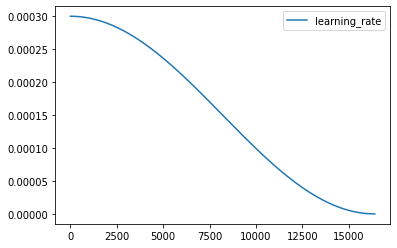

In [ ]:
import pandas as pd
pd.DataFrame(data={'learning_rate': learning_rates}).plot.line()

Learning rate schedulers make training more stable, they also improve performance on average. While the performance gains in this example may not be as big, the improvements become more apparent the harder the task (and dataset) is.

More advanced schedulers will not be shown here as the setup is too simple to warrant their use. They will be discussed as the need arises.

# Convergence

How do I know if my model has converged? Well the only way to find out is to train one. Let's reinstantiate a model.

In [ ]:
model = MLPClassifier(input_dim=784, hidden_dim=1024, output_dim=10, 
                      n_layers=2, activation='relu', dropout=0.5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

epochs = 50
iters = epochs * len(train_loader)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=iters, eta_min=0)

We'll be training this for *a lot* of epochs. We'll be taking note of the losses as we'll be plotting the loss curves later. This is the only way we can inspect if our model has converged.

In [ ]:
train_losses = []
test_losses = []

for e in range(1, epochs + 1):
    train_loss, train_acc = 0, 0

    model.train()
    for x, y in tqdm(train_loader):
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()
        train_acc += accuracy(out, y)
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    model.eval()
    test_loss, test_acc = 0, 0
    for x, y in tqdm(test_loader):
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y)

        test_loss += loss.item()
        test_acc += accuracy(out, y)
    test_loss /= len(test_loader)
    test_acc /= len(test_loader)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print("\nEpoch {:3d} | Train Loss {:.4f} | Test Loss {:.4f} | Train Acc {:.2f}% | Test Acc {:.2f}%".format(e, train_loss, test_loss, train_acc * 100, test_acc * 100))

  2%|▏         | 28/1641 [00:00<00:05, 274.48it/s]


Epoch   1 | Train Loss 0.9226 | Test Loss 0.1751 | Train Acc 85.32% | Test Acc 94.95%


  2%|▏         | 26/1641 [00:00<00:06, 258.90it/s]


Epoch   2 | Train Loss 0.3049 | Test Loss 0.1505 | Train Acc 91.86% | Test Acc 95.58%


  2%|▏         | 27/1641 [00:00<00:05, 269.50it/s]


Epoch   3 | Train Loss 0.2785 | Test Loss 0.1426 | Train Acc 92.65% | Test Acc 96.14%


  2%|▏         | 27/1641 [00:00<00:06, 268.92it/s]


Epoch   4 | Train Loss 0.2637 | Test Loss 0.1461 | Train Acc 93.31% | Test Acc 95.98%


  2%|▏         | 28/1641 [00:00<00:05, 273.07it/s]


Epoch   5 | Train Loss 0.2499 | Test Loss 0.1319 | Train Acc 93.79% | Test Acc 96.44%


  2%|▏         | 25/1641 [00:00<00:06, 247.64it/s]


Epoch   6 | Train Loss 0.2372 | Test Loss 0.1392 | Train Acc 94.16% | Test Acc 96.29%


  2%|▏         | 27/1641 [00:00<00:06, 263.49it/s]


Epoch   7 | Train Loss 0.2297 | Test Loss 0.1342 | Train Acc 94.50% | Test Acc 96.80%


  2%|▏         | 27/1641 [00:00<00:06, 264.33it/s]


Epoch   8 | Train Loss 0.2093 | Test Loss 0.1345 | Train Acc 94.96% | Test Acc 96.65%


  2%|▏         | 27/1641 [00:00<00:06, 265.12it/s]


Epoch   9 | Train Loss 0.2165 | Test Loss 0.1284 | Train Acc 95.02% | Test Acc 96.70%


  2%|▏         | 27/1641 [00:00<00:06, 262.78it/s]


Epoch  10 | Train Loss 0.2130 | Test Loss 0.1327 | Train Acc 95.15% | Test Acc 96.96%


  2%|▏         | 27/1641 [00:00<00:06, 266.52it/s]


Epoch  11 | Train Loss 0.1896 | Test Loss 0.1254 | Train Acc 95.58% | Test Acc 97.02%


  2%|▏         | 27/1641 [00:00<00:06, 262.83it/s]


Epoch  12 | Train Loss 0.1908 | Test Loss 0.1408 | Train Acc 95.65% | Test Acc 97.03%


  2%|▏         | 27/1641 [00:00<00:06, 263.85it/s]


Epoch  13 | Train Loss 0.1817 | Test Loss 0.1356 | Train Acc 95.82% | Test Acc 97.18%


  2%|▏         | 25/1641 [00:00<00:06, 248.20it/s]


Epoch  14 | Train Loss 0.1759 | Test Loss 0.1532 | Train Acc 95.98% | Test Acc 97.27%


  2%|▏         | 26/1641 [00:00<00:06, 251.44it/s]


Epoch  15 | Train Loss 0.1667 | Test Loss 0.1343 | Train Acc 96.21% | Test Acc 97.18%


  2%|▏         | 27/1641 [00:00<00:05, 269.08it/s]


Epoch  16 | Train Loss 0.1548 | Test Loss 0.1350 | Train Acc 96.33% | Test Acc 97.30%


  2%|▏         | 27/1641 [00:00<00:06, 265.72it/s]


Epoch  17 | Train Loss 0.1493 | Test Loss 0.1213 | Train Acc 96.51% | Test Acc 97.41%


  2%|▏         | 28/1641 [00:00<00:05, 271.49it/s]


Epoch  18 | Train Loss 0.1473 | Test Loss 0.1270 | Train Acc 96.66% | Test Acc 97.65%


  2%|▏         | 27/1641 [00:00<00:06, 266.38it/s]


Epoch  19 | Train Loss 0.1438 | Test Loss 0.1174 | Train Acc 96.88% | Test Acc 97.59%


  1%|▏         | 24/1641 [00:00<00:06, 237.00it/s]


Epoch  20 | Train Loss 0.1294 | Test Loss 0.1169 | Train Acc 97.10% | Test Acc 97.81%


  2%|▏         | 25/1641 [00:00<00:06, 248.66it/s]


Epoch  21 | Train Loss 0.1265 | Test Loss 0.1229 | Train Acc 97.18% | Test Acc 97.89%


  2%|▏         | 27/1641 [00:00<00:06, 264.12it/s]


Epoch  22 | Train Loss 0.1148 | Test Loss 0.1236 | Train Acc 97.41% | Test Acc 97.71%


  2%|▏         | 26/1641 [00:00<00:06, 256.65it/s]


Epoch  23 | Train Loss 0.1060 | Test Loss 0.1263 | Train Acc 97.60% | Test Acc 97.80%


  2%|▏         | 27/1641 [00:00<00:06, 267.52it/s]


Epoch  24 | Train Loss 0.1019 | Test Loss 0.1380 | Train Acc 97.61% | Test Acc 97.78%


  2%|▏         | 27/1641 [00:00<00:06, 266.66it/s]


Epoch  25 | Train Loss 0.1011 | Test Loss 0.1230 | Train Acc 97.71% | Test Acc 97.81%


  2%|▏         | 26/1641 [00:00<00:06, 254.37it/s]


Epoch  26 | Train Loss 0.0909 | Test Loss 0.1243 | Train Acc 97.92% | Test Acc 97.99%


  2%|▏         | 25/1641 [00:00<00:06, 242.02it/s]


Epoch  27 | Train Loss 0.0795 | Test Loss 0.1256 | Train Acc 98.10% | Test Acc 97.99%


  2%|▏         | 27/1641 [00:00<00:06, 264.95it/s]


Epoch  28 | Train Loss 0.0825 | Test Loss 0.1259 | Train Acc 98.11% | Test Acc 97.94%


  2%|▏         | 26/1641 [00:00<00:06, 258.68it/s]


Epoch  29 | Train Loss 0.0718 | Test Loss 0.1333 | Train Acc 98.24% | Test Acc 98.03%


  2%|▏         | 26/1641 [00:00<00:06, 258.49it/s]


Epoch  30 | Train Loss 0.0648 | Test Loss 0.1291 | Train Acc 98.43% | Test Acc 98.14%


  2%|▏         | 28/1641 [00:00<00:05, 273.55it/s]


Epoch  31 | Train Loss 0.0674 | Test Loss 0.1256 | Train Acc 98.34% | Test Acc 98.12%


  2%|▏         | 26/1641 [00:00<00:06, 252.48it/s]


Epoch  32 | Train Loss 0.0587 | Test Loss 0.1397 | Train Acc 98.53% | Test Acc 98.15%


  2%|▏         | 26/1641 [00:00<00:06, 256.66it/s]


Epoch  33 | Train Loss 0.0527 | Test Loss 0.1373 | Train Acc 98.76% | Test Acc 98.19%


  2%|▏         | 27/1641 [00:00<00:06, 264.71it/s]


Epoch  34 | Train Loss 0.0488 | Test Loss 0.1459 | Train Acc 98.82% | Test Acc 98.18%


  2%|▏         | 26/1641 [00:00<00:06, 258.45it/s]


Epoch  35 | Train Loss 0.0452 | Test Loss 0.1435 | Train Acc 98.87% | Test Acc 98.26%


  2%|▏         | 28/1641 [00:00<00:05, 276.73it/s]


Epoch  36 | Train Loss 0.0482 | Test Loss 0.1359 | Train Acc 98.91% | Test Acc 98.22%


  2%|▏         | 28/1641 [00:00<00:05, 272.95it/s]


Epoch  37 | Train Loss 0.0418 | Test Loss 0.1452 | Train Acc 98.95% | Test Acc 98.23%


  2%|▏         | 27/1641 [00:00<00:06, 267.95it/s]


Epoch  38 | Train Loss 0.0384 | Test Loss 0.1486 | Train Acc 99.04% | Test Acc 98.27%


  2%|▏         | 27/1641 [00:00<00:06, 264.80it/s]


Epoch  39 | Train Loss 0.0339 | Test Loss 0.1543 | Train Acc 99.15% | Test Acc 98.30%


  2%|▏         | 27/1641 [00:00<00:06, 264.62it/s]


Epoch  40 | Train Loss 0.0357 | Test Loss 0.1545 | Train Acc 99.09% | Test Acc 98.34%


  2%|▏         | 27/1641 [00:00<00:06, 265.16it/s]


Epoch  41 | Train Loss 0.0333 | Test Loss 0.1481 | Train Acc 99.13% | Test Acc 98.42%


  2%|▏         | 28/1641 [00:00<00:05, 270.75it/s]


Epoch  42 | Train Loss 0.0295 | Test Loss 0.1526 | Train Acc 99.22% | Test Acc 98.39%


  2%|▏         | 25/1641 [00:00<00:06, 248.65it/s]


Epoch  43 | Train Loss 0.0307 | Test Loss 0.1543 | Train Acc 99.27% | Test Acc 98.32%


  2%|▏         | 26/1641 [00:00<00:06, 248.66it/s]


Epoch  44 | Train Loss 0.0276 | Test Loss 0.1562 | Train Acc 99.29% | Test Acc 98.42%


  2%|▏         | 27/1641 [00:00<00:06, 261.71it/s]


Epoch  45 | Train Loss 0.0248 | Test Loss 0.1569 | Train Acc 99.32% | Test Acc 98.38%


  2%|▏         | 26/1641 [00:00<00:06, 252.16it/s]


Epoch  46 | Train Loss 0.0255 | Test Loss 0.1574 | Train Acc 99.33% | Test Acc 98.39%


  2%|▏         | 27/1641 [00:00<00:06, 268.48it/s]


Epoch  47 | Train Loss 0.0261 | Test Loss 0.1573 | Train Acc 99.30% | Test Acc 98.42%


  2%|▏         | 27/1641 [00:00<00:06, 267.52it/s]


Epoch  48 | Train Loss 0.0221 | Test Loss 0.1562 | Train Acc 99.38% | Test Acc 98.44%


  2%|▏         | 28/1641 [00:00<00:05, 272.24it/s]


Epoch  49 | Train Loss 0.0246 | Test Loss 0.1564 | Train Acc 99.34% | Test Acc 98.44%


100%|██████████| 547/547 [00:00<00:00, 824.90it/s]


Epoch  50 | Train Loss 0.0265 | Test Loss 0.1564 | Train Acc 99.37% | Test Acc 98.44%


Let's plot.

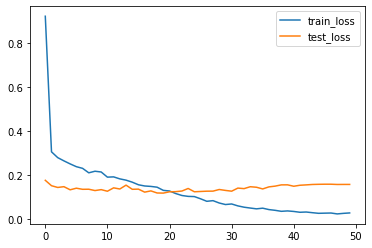

In [ ]:
pd.DataFrame(data={'train_loss': train_losses, 'test_loss': test_losses}).plot.line()

Once we see that the testing loss is stable and the training loss has stopped going down, we can say that the model has converged.